This is my version of the contests for dogbreed
Wanted to start from scratch

First setup for the fast ai stuff
Reload all the modules and inline plotting

In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Basic fast ai import libraries

In [3]:
# This file contains all the main external libs we'll use
from fastai.imports import *

fast ai libraries

In [4]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

Set up data path

In [19]:
PATH='data/dogbreed'
TRAINDIR='train'
LABELS='labels.csv'

Check for CUDA and GPU availability
Set it up if needed
This leads to faster learning

In [6]:
torch.cuda.is_available()
torch.backends.cudnn.enabled

False

Check the data, read the csv file and load the labels to see how the counts are
Usually we want all the classes to have similar number of samples

In [25]:
df = pd.read_csv(f'{PATH}/{LABELS}'); df[:10]

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


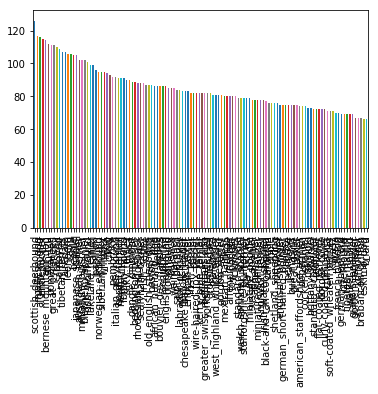

In [13]:
df['breed'].value_counts().plot(kind='bar')

Set the architecture and image size
Let use a pre-trained model for now.

In [16]:
arch=resnet34
sz=224

load the transforms for the particular architecture

In [21]:
tfms=tfms_from_model(arch, sz)

Load the ImageClassifierData which loads all the files into a data object. Once we load this we can try to train it

In [31]:
data = ImageClassifierData.from_csv(PATH, TRAINDIR, f'{PATH}/{LABELS}', tfms=tfms, suffix='.jpg')

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

  0%|          | 0/128 [00:00<?, ?it/s]

/home/bhaskar/MyCode/fastai/courses/dl1/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


  1%|          | 1/128 [00:44<1:33:59, 44.41s/it]